# Final assignment 

## 1. Motivation

### 1.1 What is your dataset?

We first decided to analyze and visualize car accidents in Iceland, the dataset was obtained from Icelandic Transport Authority. We also wanted to do further analysis of car accidents with respect to weather so we combined the car accident data with weather data obtained from the Meteorological Office of Iceland.
To further support our findings in the analysis we also got data about traffick flow from the Icelandic Road Administration and some statistics about Iceland's population, for example the number of cars in Iceland from Statistic Iceland

### 1.2 Why did you choose this/these particular data set(s)?

Iceland has a population that relies heavily on their cars. The capital area of Iceland does not have great public transport that you can use and rely on at all hours of the day. This leads to the population being quite dependent on private cars. It is known that the more cars there are on the road there are more chances of accidents happening. The weather in Iceland is highly unpredictable as well. This means that people that might have the opportunity to bike or walk to their destinations are less likely to use this option. 
This project takes a close look at accidents that have occured in Iceland from the year 2007 to 2020 in relation to the weather. By using data visualization techniques and unsupervised learning we will be able to find patterns in the data that can be useful to make decisions in regards to traffic decisions. This analysis will focus mostly on the capital area since there are most accidents in that area, however data from the rest of the country will be visible for those interested. 


###  1.3 What was your goal for the end user's experience?

To be able to explore the numbers about car accidents and weather in Iceland in a visual way with help of plots, bar charts, maps and interactive maps. We hope to guide the user through a large data set in a simple and comprehensible visualization. 


## 2. Basic stats 

We begin by importing all of the packages needed for the project

In [1]:
import numpy as np
#Import packages
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from bokeh.io import output_file, show, push_notebook, output_notebook
from bokeh.plotting import figure #, output_file, save
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.palettes import Spectral11
from bokeh.transform import factor_cmap
from bokeh.models import Legend
from datetime import date
from bokeh.models import CustomJS, DateRangeSlider
import os
#from bokeh.sampledata.stocks import AAPL, GOOG, IBM, MSFT
from ipywidgets import interact
import pandas as pd
import bokeh
output_notebook()
#import packages
import matplotlib.pyplot as plt
from scipy import stats
from urllib.request import urlopen
import seaborn as sns
from datetime import datetime
import calendar
import warnings
from pandas.core.common import SettingWithCopyWarning
import requests
#TABS for bokeh
from bokeh.io import show
from bokeh.models import Panel, Tabs
#import folium
import folium
from folium import plugins
from folium.plugins import HeatMap
import calendar


Loading BokehJS ...

In [2]:
#Create colors 
l = []
for color in (Spectral11):
    l.append(color)
l.append("#c9d9d3")
l.append("#718dbf")
l.append("#e84d60")

In [3]:
# remove warning messages
warnings.filterwarnings('ignore')

### 2.1 Data preperation and cleaning 
#### *Write about your choices in data cleaning and preprocessing*

*The data we will use was obtained from 4 different institutes in Iceland. The data is not public so to obtain the data we had to contact personnel within these institutes.*


Now we import all of the datasets 

In [4]:
weather_data = pd.read_csv('rvk_2007_2020.txt',  delimiter=r"\s+")

In [5]:
data = pd.read_pickle(r'mypickle.pickle')

In [6]:
dataflow = pd.read_excel('flow.xlsx')

In [7]:
cars = pd.read_excel('cars.xlsx')

Here we create date and time varibles for both the weather and accidents dataset.

In [8]:
#adding date time varibles to our weather data set
weather_data['hour'] = pd.DatetimeIndex(weather_data['TIMI']).hour
weather_data['year'] = pd.DatetimeIndex(weather_data['STOD']).year
weather_data['weekday'] = pd.DatetimeIndex(weather_data['STOD']).weekday
weather_data['month'] = pd.DatetimeIndex(weather_data['STOD']).month
weather_data['Date'] =  pd.DatetimeIndex(weather_data['STOD']).date

In [9]:
#adding date time varibles to our accidents data set
data['year'] = pd.DatetimeIndex(data['Dagsetning og tími']).year
data['weekday'] = pd.DatetimeIndex(data['Dagsetning og tími']).weekday
data['month'] = pd.DatetimeIndex(data['Dagsetning og tími']).month
data['hour'] = pd.DatetimeIndex(data['Dagsetning og tími']).hour
data['minute'] = pd.DatetimeIndex(data['Dagsetning og tími']).minute
data['second'] = pd.DatetimeIndex(data['Dagsetning og tími']).second
data['Time_str'] =  pd.DatetimeIndex(data['Dagsetning og tími']).strftime("%H:%M")
data['weekday_name'] = pd.to_datetime(data['Dagsetning og tími']).dt.day_name()
data['Date'] = pd.DatetimeIndex(data['Dagsetning og tími']).date
data['month_name'] = pd.DatetimeIndex(data['Dagsetning og tími']).month_name

Now we merge our data sets to create the main data set used in this project. They will be joined on date by keeping all of the accident data.

In [10]:
#merge using inner join on date
dataAll = pd.merge(data, weather_data, how = 'inner', on = ["hour", "Date", "month", "weekday", "year"])


Here we do some more data cleaning, removing variables that are repeated and variables what we do not use. Such as  'X-Hnit', 'Y-Hnit', these are coordinates that follow an Icelandic system that needed to be changed into longitude and latitude. 


The accident data obtained from the Icelandic Transport Authority had the coordinate values encoded in ISNET93 (or ISN93 ), a reference coordinate system for GPS measurements adopted for Iceland by the National Land Survey of Iceland in 1993.  Getting the formula for Converting these values is very complicated and no functions exist in python do to that. Fortunately, An Icelandic website exists for transforming the coordinates to normal longitude and latitude values. We managed to call their API for every coordinate in our dataset, around 88k API calls, which ran for around around 10 hours. 


In [11]:
#Drop varibles that are repeated and will not be used in our analysis
dataAll = dataAll.drop(columns = [ 'Ár', 'X-Hnit', 'Y-Hnit', 'Dagsetning og tími', 'STOD', 'Mánuður', 'minute', 'second', 'TIMI' ])
#drop na values
dataAll = dataAll.replace({'(null)': np.nan})
dataAll = dataAll.dropna()

Weather variables need to be converted into numeric values to be able to use in analyses. 

In [12]:
#convert weather varibles to numeric form
dataAll['T'] = pd.to_numeric(dataAll['T'], downcast='float')
dataAll['TX'] = pd.to_numeric(dataAll['TX'])
dataAll['TN'] = pd.to_numeric(dataAll['TN'])
dataAll['RH'] =pd.to_numeric(dataAll['RH'])
dataAll['P'] = pd.to_numeric(dataAll['P'])
dataAll['D'] = pd.to_numeric(dataAll['D'])
dataAll['F'] = pd.to_numeric(dataAll['F'])
dataAll['FG'] = pd.to_numeric(dataAll['FG'])
dataAll['FX'] = pd.to_numeric(dataAll['FX'])
dataAll['R'] =pd.to_numeric(dataAll['R'])

Here we create categorical variables which indicate some weather conditions. We have created a **freezing** variables which indicates where the temperature is below 0°C. We also created a **precipitation** variable with 0 and 1 indicating whether there is precipitation or not. The **wind** variable was created from the wind gusts measurement and rated into categories according to the Meteorological Office of Iceland. These groups are displayed in the table below.

\begin{array}{|r|l|r|}
\hline
\textbf{Wind speeds in m/s} & \textbf{Description}  & indicator\\
\hline
>5 & \text{Very slow winds}& 0 \\
5-10 & \text{Slow winds}& 1 \\
10-20 & \text{Considerable winds} & 2\\
20-30 & \text{Very windy, people need to be aware} & 3\\
<30 & \text{Dangerous winds, a storm, people should not be out}& 4 \\
\hline
\end{array}




We have created these categorical variables to be able to make indicators for both plots and machine learning techniques we use.

In [13]:
#create functions for categorical varibles mentioned above
def freezing(row):
    if row['T'] > 0:
        val = 0
    elif row['T'] <= 0:
        val = 1
    return val

def winds(row):
    if row['FG'] < 5:
        val = 0
    elif (row['FG'] >= 5) and (row['FG'] < 10):
        val = 1
    elif (row['FG'] >= 10) and (row['FG'] < 20) :
        val = 2
    elif (row['FG'] >= 20) and (row['FG'] < 30):
        val = 3
    else:
        val = 4
    return val

def percip(row):
    if row['R'] > 0:
        val = 1
    elif row['R'] <= 0:
        val = 0
    return val

dataAll['Freezing'] = dataAll.apply(freezing, axis=1)
dataAll['Winds'] = dataAll.apply(winds, axis=1)
dataAll['precipitation'] = dataAll.apply(percip, axis=1)



### 2.2  Basic Statistics 
#### *Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.*

#### 2.2.1 Basic stats - Accident

We will begin by looking at overview of the data set by looking at a summary statistic

In [14]:
round(dataAll.describe(),2)

Meiðsli      long       lat      year   weekday     month      hour  \
count  88431.00  88431.00  88431.00  88431.00  88431.00  88431.00  88431.00   
mean       3.83    -21.21     64.33   2013.51      2.73      6.50     13.77   
std        0.45      1.81      0.55      4.07      1.87      3.53      4.75   
min        1.00    -24.46     63.40   2007.00      0.00      1.00      0.00   
25%        4.00    -21.93     64.10   2010.00      1.00      3.00     11.00   
50%        4.00    -21.87     64.13   2014.00      3.00      7.00     14.00   
75%        4.00    -21.75     64.15   2017.00      4.00     10.00     17.00   
max        4.00    -13.66     66.53   2020.00      6.00     12.00     23.00   

              T        TX        TN        RH         P         D         F  \
count  88431.00  88431.00  88431.00  88431.00  88431.00  88431.00  88431.00   
mean       5.80      6.30      5.32     73.11   1004.00    166.18      4.16   
std        5.51      5.57      5.48     14.00     14.78     99.07      2.62   
min      -14.10    -13.50    -14.30     21.00    939.70      0.00      0.00   
25%        1.50      2.00      1.00     64.00    994.70     88.00      2.20   
50%        5.90      6.40      5.50     75.00   1005.60    151.00      3.60   
75%       10.30     10.80      9.80     84.00   1014.70    242.00      5.60   
max       25.10     26.40     24.50     98.00   1049.80    360.00     23.40   

             FX        FG         R  Freezing     Winds  precipitation  
count  88431.00  88431.00  88431.00  88431.00  88431.00       88431.00  
mean       4.88      8.24      0.11      0.17      1.05           0.17  
std        2.76      4.69      0.39      0.37      0.80           0.38  
min        0.00      0.00      0.00      0.00      0.00           0.00  
25%        2.80      4.70      0.00      0.00      0.00           0.00  
50%        4.30      7.30      0.00      0.00      1.00           0.00  
75%        6.40     11.00      0.00      0.00      2.00           0.00  
max       23.40     36.10     10.20      1.00      4.00           1.00

Here we have an overview of the combined data set. The most important thing we see here is that the most common accident type, "Meiðsli" is 4. This accident type has "No injuries". 

Lets take a better look at the different accident types and its distribution 

In [15]:
data_types = dataAll.groupby(['Meiðsli'])
types = dataAll.groupby(['Meiðsli']).size().reset_index(name='Count') 
types_source = ColumnDataSource(types)

p_types = figure(plot_width=800, plot_height=300)
p_types.vbar(x ="Meiðsli", top = "Count", alpha=0.5, width=0.9, source=types_source)
show(p_types)

In [16]:
types['Percentage (%)'] = round(types['Count']/len(dataAll),3)*100
types

Meiðsli  Count  Percentage (%)
0        1    162             0.2
1        2   2162             2.4
2        3  10081            11.4
3        4  76026            86.0

We see that the mjority of the data set is within category 4, this category denotes accidents with **"No injuries"**. We see that there is a large different between these groups and fortunatley only 0.2% of the dataset are fatalites. 

 To get a better feel for the data we will take a look at a time series of the accidents from the year 2007-2020

In [19]:
data_date = dataAll.groupby(['Meiðsli','Date'])
df2_date = dataAll.groupby(['Meiðsli','Date']).size().reset_index(name='countCat') 
df3_date = df2_date.groupby(['Meiðsli'])['countCat'].sum().reset_index()
df_date = df2_date.merge(df3_date, on = 'Meiðsli' ,how='left')
#df['ratio'] = df['countCat_x']/df['countCat_y']
blah = df_date.pivot(index='Date', columns="Meiðsli", values="countCat_x").reset_index()
accidents_date = blah.fillna(0)

#### 2.2.2 Accidents - Time series

We will only take a look at accidents with no injuriey for the time series 

In [20]:
accidentsD = accidents_date
accidentsD.columns = ['Date','Fatal','Serious','Minor injuries','No injuries']
accidents_date['total']  = accidents_date['Fatal'] +  accidents_date['Serious'] +  accidents_date['Minor injuries'] +  accidents_date['No injuries'] 
accidents_date.head()
accidentsD_source = ColumnDataSource(accidents_date)


In [19]:
p_TS = figure(plot_width=800, plot_height=300, x_axis_type='datetime')
p_TS.line("Date", "total", line_width=1, color=l[0], alpha=1, source=accidentsD_source)
p_TS.xaxis.axis_label = "Year"
p_TS.yaxis.axis_label = "Number of accidents"
show(p_TS)


We see that there might be some seasonal changes when it comes to accidents here, we will take a further look at the this in section 3. Data analysis. *Note that a toggle view is avalible by selecting a certain part of the plot from the box and magnifying glass icon.* If zoomed into 2020 we see there is a  drop in March to April 2020, this is most likely due to the lockdown enforced due to the Covid-19 pandemic.

#### 2.2.3 Accidents - Yearly averages

Lets take a look at a couple of averages, yearly averages.

In [21]:
data_hour = dataAll.groupby(['Meiðsli','year'])
df2 = dataAll.groupby(['Meiðsli','year']).size().reset_index(name='countCat') 
df3 = df2.groupby(['Meiðsli'])['countCat'].sum().reset_index()
df = df2.merge(df3, on = 'Meiðsli' ,how='left')
#df['ratio'] = df['countCat_x']/df['countCat_y']
blah = df.pivot(index='year', columns="Meiðsli", values="countCat_x").reset_index()
listofaccidents = blah.fillna(0)

In [22]:
listofaccidents[['year',1]].columns = ['year','Fatal']

In [23]:
accidents = listofaccidents
accidents.columns = ['year','Fatal','Serious','Minor injuries','No injuries']
accidents_source = ColumnDataSource(listofaccidents)
source_all = ColumnDataSource(listofaccidents)

In [24]:
p_fatal = figure(plot_width=800, plot_height=300)#, x_axis_type='datetime')
p_fatal.vbar(x ="year", top = "Fatal", alpha=0.5, width=0.9, source=accidents_source)
p_fatal.line("year", "Fatal", line_width=1, color=l[0], alpha=0.5, source=accidents_source)
p_fatal.xaxis.axis_label = "Year"
p_fatal.yaxis.axis_label = "Number of accidents"
fataltab = Panel(child=p_fatal, title="Fatal")

p_serios = figure(plot_width=800, plot_height=300)#, x_axis_type='datetime')
p_serios.vbar(x ="year", top = "Serious", alpha=0.5, width=0.9, source=accidents_source)
p_serios.line("year", "Serious", line_width=1, color=l[0], alpha=0.5, source=accidents_source)
p_serios.xaxis.axis_label = "Year"
p_serios.yaxis.axis_label = "Number of accidents"
serioustab = Panel(child=p_serios, title="Serious")

p_minor = figure(plot_width=800, plot_height=300)#, x_axis_type='datetime')
p_minor.vbar(x ="year", top = "Minor injuries", alpha=0.5, width=0.9, source=accidents_source)
p_minor.line("year", "Minor injuries", line_width=1, color=l[0], alpha=0.5, source=accidents_source)
p_minor.xaxis.axis_label = "Year"
p_minor.yaxis.axis_label = "Number of accidents"
minortab = Panel(child=p_minor, title="Minor")

p_no = figure(plot_width=800, plot_height=300)#, x_axis_type='datetime')
p_no.vbar(x ="year", top = "No injuries", alpha=0.5, width=0.9, source=accidents_source)
p_no.line("year", "No injuries", line_width=1, color=l[0], alpha=0.5, source=accidents_source)
p_no.xaxis.axis_label = "Year"
p_no.yaxis.axis_label = "Number of accidents"
notab = Panel(child=p_no, title="No injuries")

yearly_average = (Tabs(tabs=[notab,minortab,serioustab,fataltab]))


In [25]:
from bokeh.plotting import figure, output_file, save
output_file("yearly_average.html")
save(yearly_average)

'C:\\Users\\Bex\\Documents\\Social\\yearly_average.html'

Here we see the yearly averages of car accidents in Iceland for the different accident types. We see that the years 2008 and 2020 seem to differ from the others by being lower than their neighborhing years for no injuries. Minor injuries seem to have decreased by a 300 accidents from 2007-2020. Serious injuries and fatalities are less than 3% of the data set and hard to make any concrete observations in regard to yearly changes. 

#### 2.2.4. Basic statistics - Weather 

Here we have an overview of all of the weather variables, the one denoted in bold are the ones we will be taking a closer look at.

\begin{array}{|r|l|r|}
\hline
\textbf{Variable} & \textbf{Description}\\
\hline
\textbf{T} & \text{Temperature (1 minute avrage) °C} \\
TX & \text{Maximum temerature (1 minute maximum) °C} \\
TN & \text{Maximum temerature (1 minute minimum) °C} \\
\textbf{RH} & \text{Humidity (1 minute avrage) % } \\
\textbf{P} & \text{Pressure calculated at sea level, hPa}\\
D & \text{Winds direction (10 minute avrage), degrees}\\
\textbf{F} & \text{ Average wind speed (10 minute avrage), m/s}\\
FX & \text{ Maximum 10 minute average winds, m/s}\\
\textbf{FG} & \text{Wind gusts, m/s }\\
\textbf{R} & \text{ Precipitation, mm }\\
\hline
\end{array}

Lets take a look at the summary statistcs again for the weather varibles

In [24]:
round(dataAll[["T", "TX", "TN", "RH", "P", "D", "F", "FX", "FG", "R"]].describe(),2)

T        TX        TN        RH         P         D         F  \
count  88431.00  88431.00  88431.00  88431.00  88431.00  88431.00  88431.00   
mean       5.80      6.30      5.32     73.11   1004.00    166.18      4.16   
std        5.51      5.57      5.48     14.00     14.78     99.07      2.62   
min      -14.10    -13.50    -14.30     21.00    939.70      0.00      0.00   
25%        1.50      2.00      1.00     64.00    994.70     88.00      2.20   
50%        5.90      6.40      5.50     75.00   1005.60    151.00      3.60   
75%       10.30     10.80      9.80     84.00   1014.70    242.00      5.60   
max       25.10     26.40     24.50     98.00   1049.80    360.00     23.40   

             FX        FG         R  
count  88431.00  88431.00  88431.00  
mean       4.88      8.24      0.11  
std        2.76      4.69      0.39  
min        0.00      0.00      0.00  
25%        2.80      4.70      0.00  
50%        4.30      7.30      0.00  
75%        6.40     11.00      0.00  
max       23.40     36.10     10.20

All the temperature variables have a mean around 5-6°C, this is an avrage over all of the years. The maximum temperature reaches about 25-26 °C, this does not happen oten and can be seen below in the histograms for  T, TX and TN where the average is between 0°C to 15°C.

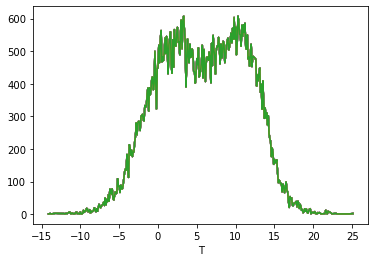

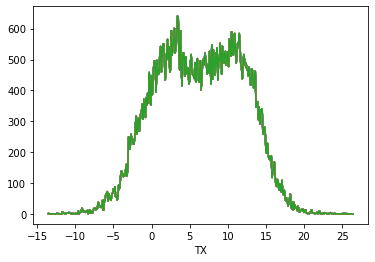

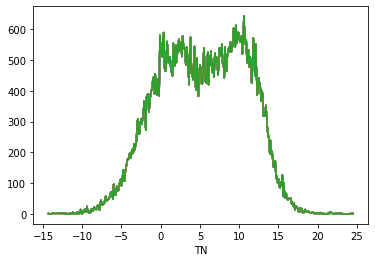

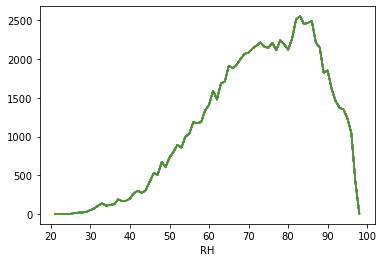

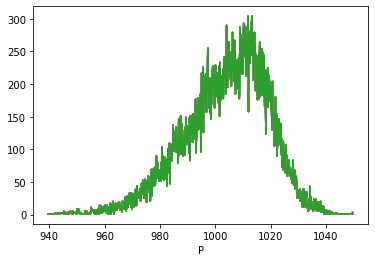

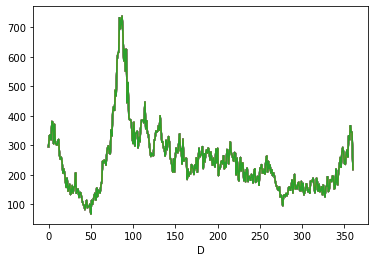

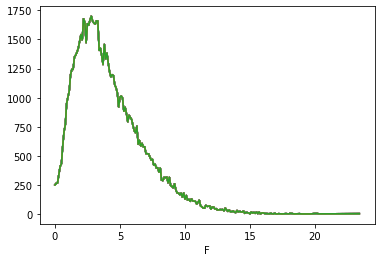

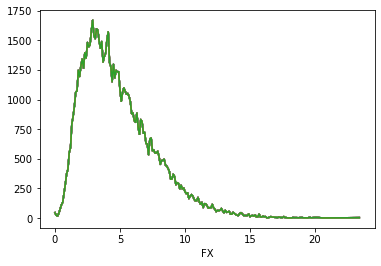

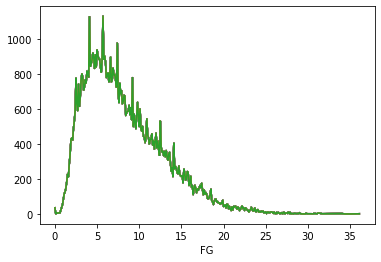

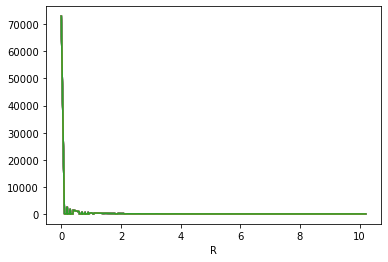

In [25]:
varweather = ["T", "TX", "TN", "RH", "P", "D", "F", "FX", "FG", "R"]
for  t in varweather:
    dataAll.groupby(t).count().plot(legend = False)

Here we have the distribution for the different weather observations. One interesting distribution to note is the precepitation variable, R, it seems to have almost all values around 0. We have data down to the second which makes sense that there might have been a rainy day but wont be raining every second of the day but comes in waves.

#### 2.2.5. Weather - Time series

Now we will take a closer look at the weather data in time series plots.

In [26]:
sourceall= ColumnDataSource(dataAll[['Date','T', 'F', 'RH', 'R', 'P']])

In [27]:
p1weather = figure(plot_width=800, plot_height=300, x_axis_type='datetime')
p1weather.line("Date", "T", line_width=0.5, color=l[0], alpha=0.5, source=sourceall)
p1weather.xaxis.axis_label = "Year"
p1weather.yaxis.axis_label = "°C"
tab1weather = Panel(child=p1weather, title="Temperature")

p2weather = figure(plot_width=800, plot_height=300, x_axis_type='datetime')
p2weather.line("Date", "F", line_width=0.5, color=l[0], alpha=0.5, source=sourceall)
p2weather.xaxis.axis_label = "Year"
p2weather.yaxis.axis_label = "m/s"
tab2weather = Panel(child=p2weather, title="Mean wind speed")

p3weather = figure(plot_width=800, plot_height=300, x_axis_type='datetime')
p3weather.line("Date", "RH", line_width=0.5, color=l[0], alpha=0.5, source=sourceall)
p3weather.xaxis.axis_label = "Year"
p3weather.yaxis.axis_label = "%"
tab3weather = Panel(child=p3weather, title="Humidity")

p4weather = figure(plot_width=800, plot_height=300, x_axis_type='datetime')
p4weather.line("Date", "R", line_width=0.5, color=l[0], alpha=0.5, source=sourceall)
p4weather.xaxis.axis_label = "Year"
p4weather.yaxis.axis_label = "mm"
tab4weather = Panel(child=p4weather, title="Percipitation")

p5weather = figure(plot_width=800, plot_height=300, x_axis_type='datetime')
p5weather.line("Date", "P", line_width=0.5, color=l[0], alpha=0.5, source=sourceall)
p5weather.xaxis.axis_label = "Year"
p5weather.yaxis.axis_label = "hPa"
tab5weather = Panel(child=p5weather, title="Presure")
#show(p5)
show(Tabs(tabs=[tab1weather, tab2weather, tab3weather, tab4weather, tab5weather]))


We see the obvious difference between seasons here especially when it comes to the temperature. *You can view the different weather measurements by moving between tabs.* Check out presure, there is seasonality in the presure over the years. The seasonality harder to spot in the other variables but is there. We can use the toggle view to get a better 

#### 2.2.5. Weather - Averages

It is hard to spot all the differnc ebetween months and years when it comes to the time series so now lets take a look at some averages.

In [28]:

windgusts_month= pd.DataFrame({'Maximum Wind gusts' : dataAll.groupby(['month'])['FG'].max()}).reset_index()
WG_source = ColumnDataSource(windgusts_month)
test = figure(plot_width=800, plot_height=400)
test.vbar(x='month', width=0.5, bottom=0,top='Maximum Wind gusts', color=l[0], source=WG_source, alpha=0.7)
test.xaxis.ticker = [1,2,3,4,5,6,7,8,9,10,11,12] 
tabx = Panel(child=test, title="Maximum Wind Gusts")

temp_month= pd.DataFrame({'Average temperture' : dataAll.groupby(['month'])['T'].mean()}).reset_index()
temp_source = ColumnDataSource(temp_month)
pa = figure(plot_width=800, plot_height=400)
pa.vbar(x='month', width=0.5, bottom=0,top='Average temperture', color=l[0], source=temp_source, alpha=0.7)
pa.xaxis.ticker = [1,2,3,4,5,6,7,8,9,10,11,12] 
pa.xaxis.axis_label = "Month"
pa.yaxis.axis_label = "°C"
taba = Panel(child=pa, title="Average monthly temperature")

ws_month= pd.DataFrame({'Average wind speeds' : dataAll.groupby(['month'])['F'].mean()}).reset_index()
ws_source = ColumnDataSource(ws_month)

pb = figure(plot_width=800, plot_height=400)
pb.vbar(x='month', width=0.5, bottom=0,top='Average wind speeds', color=l[0], source=ws_source, alpha=0.7)
pb.xaxis.ticker = [1,2,3,4,5,6,7,8,9,10,11,12] 
pb.xaxis.axis_label = "Month"
pb.yaxis.axis_label = "m/s"
tabb = Panel(child=pb, title="Average monthly wind speeds")

hum_month= pd.DataFrame({'Average humidity' : dataAll.groupby(['month'])['RH'].mean()}).reset_index()
hum_source = ColumnDataSource(hum_month)

pc = figure(plot_width=800, plot_height=400)
pc.vbar(x='month', width=0.5, bottom=0,top='Average humidity', color=l[0], source=hum_source, alpha=0.7)
pc.xaxis.ticker = [1,2,3,4,5,6,7,8,9,10,11,12] 
pc.xaxis.axis_label = "Month"
pc.yaxis.axis_label = "%"
tabc = Panel(child=pc, title="Average monthly humdity")


prec_month= pd.DataFrame({'Average Percipitation' : dataAll.groupby(['month'])['R'].mean()}).reset_index()
prec_source = ColumnDataSource(prec_month)

pf = figure(plot_width=800, plot_height=400)
pf.vbar(x='month', width=0.5, bottom=0,top='Average Percipitation', color=l[0], source=prec_source, alpha=0.7)
pf.xaxis.ticker = [1,2,3,4,5,6,7,8,9,10,11,12] 
pf.xaxis.axis_label = "Month"
pf.yaxis.axis_label = "mm"
tabd = Panel(child=pf, title="Average monthly Percipitation")


show(Tabs(tabs=[taba, tabb, tabc, tabd,tabx ]))



Here we have the difference between the months in the data set. As expected the weather is warmer in summer months and less preciptiation. One interesting thing to note is the winds seem to be the highest in april when looking at wind speed and wind gusts. 

Below we have the average weather variables compared down to the hour

In [29]:
temp_hour= pd.DataFrame({'Average temperture' : dataAll.groupby(['hour'])['T'].mean()}).reset_index()
temp_source = ColumnDataSource(temp_hour)

pa = figure(plot_width=800, plot_height=400)
pa.vbar(x='hour', width=0.5, bottom=0,top='Average temperture', color="navy", source=temp_source, alpha=0.7)
pa.xaxis.ticker = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24] 
taba = Panel(child=pa, title="Average hourly temperature")

ws_hour= pd.DataFrame({'Average wind speeds' : dataAll.groupby(['hour'])['F'].mean()}).reset_index()
ws_source = ColumnDataSource(ws_hour)

pb = figure(plot_width=800, plot_height=400)
pb.vbar(x='hour', width=0.5, bottom=0,top='Average wind speeds', color="navy", source=ws_source, alpha=0.7)
pb.xaxis.ticker = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24] 

tabb = Panel(child=pb, title="Average hourly wind speeds")

hum_hour= pd.DataFrame({'Average humidity' : dataAll.groupby(['hour'])['RH'].mean()}).reset_index()
hum_source = ColumnDataSource(hum_hour)

pc = figure(plot_width=800, plot_height=400)
pc.vbar(x='hour', width=0.5, bottom=0,top='Average humidity', color="navy", source=hum_source, alpha=0.7)
pc.xaxis.ticker = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24] 
tabc = Panel(child=pc, title="Average hourly humdity")


prec_hour= pd.DataFrame({'Average Percipitation' : dataAll.groupby(['hour'])['R'].mean()}).reset_index()
prec_source = ColumnDataSource(prec_hour)

pf = figure(plot_width=800, plot_height=400)
pf.vbar(x='hour', width=0.5, bottom=0,top='Average Percipitation', color="navy", source=prec_source, alpha=0.7)
pf.xaxis.ticker = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24] 
tabd = Panel(child=pf, title="Average hourly Percipitation")


show(Tabs(tabs=[taba, tabb, tabc, tabd]))



This shows us how the weather on an average day would look in Reykjavík Iceland. However note that this is avrages over the whole year and summer and winter months are not comparible. 

To conclude the basic statistcs we see that there is a significant difference between the amount of accidents. There are not many patters when looking at the data from the perspective of year. In part 3 we will devle further into the data set to see if we reconize any patters when it comes to the weather, accidents over different datetime measurements. The weather is quite consistent over months and we only really see two seasons, summer and winter. In part 3 we will also compare the relationship between the accidents and weather.  

## 3. Data analysis

### 3.1 Data Analysis 
#### *Describe your data analysis and explain what you've learned about the dataset.*

#### 3.1.1  Hourly comparison of accidents with weather types - Bokeh

In this section we will take a look at the different accidents types in the contex of different weather conditions. 

We begin by creating different data sets for the different weather conditions.
* Freezing
* Precipitation
* Winds

In [30]:
data_fr = dataAll[(dataAll['Freezing'] == 1)]
data_nofr = dataAll[(dataAll['Freezing'] == 0)]
data_prec = dataAll[(dataAll['precipitation'] == 1)]
data_noprec = dataAll[(dataAll['precipitation'] == 0)]
data_wind0 = dataAll[(dataAll['Winds'] == 0)]
data_wind1 = dataAll[(dataAll['Winds'] == 1)]
data_wind2 = dataAll[(dataAll['Winds'] == 2)]
data_wind3 = dataAll[(dataAll['Winds'] == 3)]
data_wind4 = dataAll[(dataAll['Winds'] == 4)]

In [31]:
#combine data sets into list for bokeh for loop
listofdata = [data_fr, data_nofr, data_prec, data_noprec,data_wind0, data_wind1, data_wind2, data_wind3, data_wind4 ]


Since the data set is quite unbalanced when it comes to types of accidents we will compare them as proportions. 

In [32]:
#calculate proportion accident types of data 
listofnewdata = [None] * len(listofdata)
for i, x in enumerate(listofdata):
    data_hour = x.groupby(['Meiðsli','hour'])
    df2 = x.groupby(['Meiðsli','hour']).size().reset_index(name='countCat') 
    df3 = df2.groupby(['Meiðsli'])['countCat'].sum().reset_index()
    df = df2.merge(df3, on = 'Meiðsli' ,how='left')
    df['ratio'] = df['countCat_x']/df['countCat_y']
    blah = df.pivot(index="hour", columns="Meiðsli", values="ratio").reset_index()
    listofnewdata[i] = blah.fillna(0)   



Dangerous wind speeds do not occur often and in the data set we do not have any fatal accidents when there are dangerous wind speed so we fill in in with zero.

In [33]:
listofnewdata[8]["Fatal"] = 0

Create column names for the accident types and create Column Data sources for all data type to be understood by Bokeh. 

In [34]:
listofnewdata[0].columns = ['hour','Fatal','Serious','Minor injuries','No injuries']
fr_source = ColumnDataSource(listofnewdata[0])

listofnewdata[1].columns = ['hour','Fatal','Serious','Minor injuries','No injuries']
nofr_source = ColumnDataSource(listofnewdata[1])

listofnewdata[2].columns = ['hour','Fatal','Serious','Minor injuries','No injuries']
perc_source = ColumnDataSource(listofnewdata[2])

listofnewdata[3].columns = ['hour','Fatal','Serious','Minor injuries','No injuries']
noperc_source = ColumnDataSource(listofnewdata[3])

listofnewdata[4].columns = ['hour','Fatal','Serious','Minor injuries','No injuries']
wind0_source = ColumnDataSource(listofnewdata[4])

listofnewdata[5].columns = ['hour','Fatal','Serious','Minor injuries','No injuries']
wind1_source = ColumnDataSource(listofnewdata[5])

listofnewdata[6].columns = ['hour','Fatal','Serious','Minor injuries','No injuries']
wind2_source = ColumnDataSource(listofnewdata[6])

listofnewdata[7].columns = ['hour','Fatal','Serious','Minor injuries','No injuries']
wind3_source = ColumnDataSource(listofnewdata[7])

listofnewdata[8].columns = ['hour','Fatal','Serious','Minor injuries','No injuries']
wind4_source = ColumnDataSource(listofnewdata[8])

Create the propotions of accidents and source for all weather conditions separately. 

In [35]:
#create source for all data
data_hour = dataAll.groupby(['Meiðsli','hour'])
df2 = dataAll.groupby(['Meiðsli','hour']).size().reset_index(name='countCat') 
df3 = df2.groupby(['Meiðsli'])['countCat'].sum().reset_index()
df = df2.merge(df3, on = 'Meiðsli' ,how='left')
df['ratio'] = df['countCat_x']/df['countCat_y']
mydata = df.pivot(index="hour", columns="Meiðsli", values="ratio").reset_index()
mydata= mydata.fillna(0)
mydata.columns = ['hour','Fatal','Serious','Minor injuries','No injuries']
sourcehours = ColumnDataSource(mydata)

Here we create the different interactive Bokeh bar plots for the different weather conditions. 

In [36]:
cat = set(['Fatal','Serious','Minor injuries','No injuries'])

#all sources except winds4 
sourcelist = [fr_source, nofr_source, perc_source, noperc_source, wind0_source, wind1_source, wind2_source, wind3_source, wind4_source, sourcehours]
plots = [None]*len(sourcelist)
for index,x in enumerate(sourcelist):
    maxy=max(max(x.data['Fatal']), max(x.data['Serious']), max(x.data['Minor injuries']), max(x.data['No injuries']))
    plots[index] = figure(x_range=(-1,24), y_range=(0,maxy+0.05), plot_height=500, plot_width = 800, title="Proportion car accident types for the 24 hour cycle",
           toolbar_location=None, tools="", x_axis_label = "Hours", y_axis_label="Proportion of accidents")
    legend_it = []

    bar ={} # to store vbars
    ### here we will do a for loop:
    for indx,i in enumerate(cat):
        bar[i] = plots[index].vbar(x='hour',  top=i, source= x, 
                        alpha = 0.9, width=0.9, color = l[indx], 
                        muted_color=l[indx], muted_alpha=0.03 ) 
        legend_it.append((i, [bar[i]]))
        push_notebook()
    legend = Legend(items=legend_it)
    legend.click_policy="mute"
    ticks = list(range(0,24))
    plots[index].xaxis[0].ticker = ticks
    plots[index].add_layout(legend, 'left')


Input the different plots into the different tabs for displaying the bar plots.

In [37]:
tab0 = Panel(child=plots[9], title="All")
tab1 = Panel(child=plots[0], title="Frost")
tab2 = Panel(child=plots[1], title="No Frost")
tab3 = Panel(child=plots[2], title="Percipitation")
tab4 = Panel(child=plots[3], title="No Percipitation")
tab5 = Panel(child=plots[4], title="Very slow winds")
tab6 = Panel(child=plots[5], title="Slow winds")
tab7 = Panel(child=plots[6], title="Windy")
tab8 = Panel(child=plots[7], title="Very Windy")
tab9 = Panel(child=plots[8], title="Dangerous Winds")
show(Tabs(tabs=[tab0, tab1, tab2, tab3, tab4, tab5, tab6, tab7, tab8, tab9]))

Alright now we have interactive plots for comparing weather conditions and accident types! 

* **Rush hour 16-18**
    * **All weather conditions** - We see that there is a significant increase in accidents around rush hour, for all accident types.
* **Rush hour 7-9**
    * **Frost** - Here we see a spike in accidents that also occur in the morning rush hour as well. This migh be due to the fact that frost occurs in the morning. When there is frost the driving conditions are harder to manage and time of the day matter a bit less. This can be seen when moving back and forth between the frost and no frost tabs where we see that the distribution of accidents flattens more out in the frost figure.
    * **Precipitation** - Here we also see a peek in accidents with injuries during the morning rush hour. However we need to take into consideration that accidents with injuries (Minor injuries, serious injuries and fatalites) are a minority class in the data set. 
* **Winds**
     * Note that winds above "Windy" do not contain a lot of observations and their plots do not show any significant relationships. 
     * Other than that it seems that winds to not significantly have any relationship to the time of the day accidents happen. 

#### 3.1.2  Year/weekday/monthly comparison of accidents with weather types - Bokeh

In [38]:
listofvar = ['year', 'weekday', 'month']
listofnewdatavar =[None]*len(listofvar)
for i, var in enumerate(listofvar):
    data_hour = dataAll.groupby(['Meiðsli',var])
    df2 = dataAll.groupby(['Meiðsli',var]).size().reset_index(name='countCat') 
    df3 = df2.groupby(['Meiðsli'])['countCat'].sum().reset_index()
    df = df2.merge(df3, on = 'Meiðsli' ,how='left')
    df['ratio'] = df['countCat_x']/df['countCat_y']
    blah = df.pivot(index=var, columns="Meiðsli", values="ratio").reset_index()
    listofnewdatavar[i] = blah.fillna(0)
    #listofnewdata[i].columns = ['hour','Fatal','Serious','Minor injuries','No injuries']
   



In [39]:
listofnewdatavar[0].columns = ['year','Fatal','Serious','Minor injuries','No injuries']
year_source = ColumnDataSource(listofnewdatavar[0])

listofnewdatavar[1].columns = ['weekday','Fatal','Serious','Minor injuries','No injuries']
weekday_source = ColumnDataSource(listofnewdatavar[1])

listofnewdatavar[2].columns = ['month','Fatal','Serious','Minor injuries','No injuries']
month_source = ColumnDataSource(listofnewdatavar[2])

In [40]:
sourcelistvar = [ year_source, weekday_source, month_source]
plotsvar = [None]*len(sourcelistvar)
for index,x,var in zip(range(0,len(sourcelistvar)), sourcelistvar, listofvar):
    maxx = max(x.data[var])
    minx = min(x.data[var])
    plotsvar[index] = figure(x_range=(minx-1,maxx+1), plot_height=500, plot_width = 800, title="Proportion car accident types",
           toolbar_location=None, tools="", x_axis_label = var, y_axis_label="Proportion of accidents")
    legend_it = []

    bar ={} # to store vbars
    ### here we will do a for loop:
    for indx,i in enumerate(cat):
        bar[i] = plotsvar[index].vbar(x=var,  top=i, source= x, 
                        alpha = 0.9, width=0.9, color = l[indx], 
                        muted_color=l[indx], muted_alpha=0.03 ) 
        legend_it.append((i, [bar[i]]))
        push_notebook()
    legend = Legend(items=legend_it)
    legend.click_policy="mute"
    ticks = list(range(minx-1,maxx+1))
    plotsvar[index].xaxis[0].ticker = ticks
    plotsvar[index].add_layout(legend, 'left')

In [41]:
tab0var = Panel(child=plots[9], title="Hour")
tab2var = Panel(child=plotsvar[0], title="Year")
tab3var = Panel(child=plotsvar[1], title="Weekday")
tab4var = Panel(child=plotsvar[2], title="Month")

show(Tabs(tabs=[ tab2var, tab4var, tab3var, tab0var]))

* Year
    * We have seen these distributions before in section 2. But now we have an opertunity to compare them! 
    * We see that accidents with injuries have a dip 2012, and increases again after that til 2016.
* Month
    * When taking a look at the no injuries there seems to be a dip around April and peaks in January. December and January are the darkest months in iceland, there is an average of 4-5 hours of daylight.
    * This can make it harder for drivers to see since the sun is mostly low over the whole day, meaning the sun shines into cars rather than ontop of cars like in the summer months. Since most accidents happens when the sun is at this levels, around rush hour, it can be assumed that this is one of the reasons we have more accidents in this month.
    * Also 20-19 hours of darkness can have a big effect on people ability to drive. 
* Weekday
    * Here we see that the number of accidents with out injury take a big drop over the weekend. This might imply that the accidents that do not have any injury are often on work days and during rush hour. 

#### 3.1.3 Analysis of traffic flow - Bokeh

In this section we will take a quick look at the traffic flow data we were able to obtain. The Road Administration was not able to supply us with hourly/daily data over traffic flow in iceland but was able to give us monlthy averages over the 13 year we are looking at. This information shows us the traffic flow for three different meters in the capital area. The map below displays the location of the three meters. 

In [42]:
mapCH = folium.Map([ 64.128288, -21.827774], zoom_start=11)
# Simple marker
folium.Marker([64.104239, -21.904006],
              popup='Flow meter 1',
              icon=folium.Icon(color='cadetblue', icon='car', prefix='fa')
             ).add_to(mapCH)
folium.Marker([64.106254, -21.852408],
              popup='Flow meter 2',
              icon=folium.Icon(color='cadetblue', icon='car', prefix='fa')
             ).add_to(mapCH)
folium.Marker([64.124167, -21.816994],
              popup='Flow meter 3',
              icon=folium.Icon(color='cadetblue', icon='car', prefix='fa')
             ).add_to(mapCH)
folium.Marker([64.146219, -21.936704],
              popup='City center',
              icon=folium.Icon(color='blue',icon='info-sign')#, prefix='fas fa')
             ).add_to(mapCH)

mapCH

Here we have the location of the three meters. The are located at the three busiest road in the capital area. It can also be seen from the map that these are main roads indicated by the color orange/red. The city center is indicated in blue.

Lets take a look at these traffic flow averages at these meters.

In [44]:
from functools import reduce
#group by year
meters1years = pd.DataFrame({'meter1' : dataflow.groupby(['year'])['meter1'].mean()}).reset_index()
meters2years = pd.DataFrame({'meter2' : dataflow.groupby(['year'])['meter2'].mean()}).reset_index()
meters3years = pd.DataFrame({'meter3' : dataflow.groupby(['year'])['meter3'].mean()}).reset_index()
metersyear = [meters1years, meters2years, meters3years ]
metersyear = reduce(lambda left,right: pd.merge(left,right,on='year'), metersyear)

#group by month
meters1mnth = pd.DataFrame({'meter1' : dataflow.groupby(['month'])['meter1'].mean()}).reset_index()
meters2mnth = pd.DataFrame({'meter2' : dataflow.groupby(['month'])['meter2'].mean()}).reset_index()
meters3mnth = pd.DataFrame({'meter3' : dataflow.groupby(['month'])['meter3'].mean()}).reset_index()
metersmnth = [meters1mnth, meters2mnth, meters3mnth ]
metersmnth = reduce(lambda left,right: pd.merge(left,right,on='month'), metersmnth)

#create Column Data Source
metersyear_source = ColumnDataSource(metersyear)

metersmnth_source = ColumnDataSource(metersmnth)


Create Bokeh interactive bar chart:

In [45]:
meters = set(['meter1','meter2','meter3'])
pflow = figure(x_range=(-1,13), y_range=(0,67000), plot_height=500, plot_width = 800, title="Traffic flow counters from the 3 meters",
           toolbar_location=None, tools="", x_axis_label = "Month", y_axis_label="Average number of cars per day")
legend_it = []

bar ={} # to store vbars
### here we will do a for loop:
for indx,i in enumerate(meters):
 bar[i] = pflow.vbar(x='month',  top=i, source= metersmnth_source, 
                 ### we will create a vbar for each meter
                  alpha = 0.9, width=0.9, color = l[indx], 
                 muted_color=l[indx], muted_alpha=0.03 ) 
 legend_it.append((i, [bar[i]]))


legend = Legend(items=legend_it)
legend.click_policy="mute"
ticks = list(range(0,24))
pflow.xaxis[0].ticker = ticks
pflow.add_layout(legend, 'left')
#p.legend.location = "top_left"
#p.legend.click_policy="hide"
tabmonths = Panel(child=pflow, title="Months")


In [46]:
meters = set(['meter1','meter2','meter3'])
pflowyr = figure(x_range=(2004,2021), y_range=(0,67000), plot_height=500, plot_width = 800, title="Traffic flow counters from the 3 meters",
           toolbar_location=None, tools="", x_axis_label = "Years", y_axis_label="Average number of cars per day")
legend_it = []

bar ={} # to store vbars
### here we will do a for loop:
for indx,i in enumerate(meters):
    bar[i] = pflowyr.vbar(x='year',  top=i, source= metersyear_source, 
                 ### we will create a vbar for each meter
                 alpha = 0.9, width=0.9, color = l[indx], 
                 muted_color=l[indx], muted_alpha=0.03 )
    legend_it.append((i, [bar[i]]))



legend = Legend(items=legend_it)
legend.click_policy="mute"
ticks = list(range(2005,2020))
pflowyr.xaxis[0].ticker = ticks
pflowyr.add_layout(legend, 'left')
tabyrs = Panel(child=pflowyr, title="Years")

show(Tabs(tabs=[tabyrs, tabmonths]))



* Years
    * Meters 1 and 3 follow a very similar increase through out the years. This can be explained by the amount of cars in iceland over all, see 3.1.3.1.
    * Meter 2 shows a less dramatic increase after 2012 compared to the other two meters. 
* Months
    * There seems to be a less of a difference between the months here. 
    * Meter 3 however shows a slight increase over the summer months this migh be due to an increase in people doing out of town. Meter 3 is located at the main road that lead out of the capital area north. 
    * Meter 1 is located from a suburb to the main city where all the offices are. This migh explain the dip in the month of July for the flow of cars. 

We will take a better look at these roads in section 3.1.4. and 3.1.5. 

##### 3.1.3.1 Amount of cars in Iceland

We saw from the figure above that the car flow has been increasing over the years.  This is most likeliy due to an increase in cars overall in the country. So we took a look at the Statsitic institute of Iceland to see if this hunch was correct. 

In [47]:
#import data regarding number of cars in iceland from 2007-2020
cars['year'] = pd.to_numeric(cars['year'])
source_cars = ColumnDataSource(cars)

In [48]:
carsp= figure(plot_width=800, plot_height=300, y_range=(0,350000))
carsp.line("year", "count", line_width=1, color=l[0], alpha=0.5, source=source_cars )
carsp.circle("year", "count", size=10, color=l[0], alpha=0.5, source=source_cars )
carsp.xaxis.axis_label = "Year"
carsp.yaxis.axis_label = "Number of cars"
show(carsp)

The hunch was right! We see that there is an increase in the number of cars over the years. The curve follows the same as the bar chart given above. 

#### 3.1.4  Heat Map changin over time - Accidents with injury injuries  - Folium

Through out this analysis we have seen that there is a big imbalance between the accident types. The accidents with no injuries are quite common but fortunately no injuries. The 13% of the accidents do have some type of injuries ranging from minor to fatal injuries is what we will be looking at in this section. We will visualize this using heat maps that show us the accidents over different times. This includes all years. 

In [49]:
#creat data set with accidents with injuries only
heat_df = dataAll[(dataAll['Meiðsli'] == 2) | (dataAll['Meiðsli'] == 3) | (dataAll['Meiðsli'] == 1)]


In [50]:
#create labeling for heatmap
months = list(['January','February','March','April','May','June','July','August','September','October','November','December'])
weekdays = list(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])


In [51]:
#create data for heat maps 
heat_month = [[[row['lat'],row['long']] for index, row in heat_df[heat_df['month'] == i].iterrows()] for i in range(0,12)]
heat_days = [[[row['lat'],row['long']] for index, row in heat_df[heat_df['weekday'] == i].iterrows()] for i in range(0,7)]
heat_hour = [[[row['lat'],row['long']] for index, row in heat_df[heat_df['hour'] == i].iterrows()] for i in range(0,24)]



In [52]:
#heat map for months
map_month = folium.Map([64.124167, -21.816994], zoom_start=11)
# Plot it on the map
hm = plugins.HeatMapWithTime(heat_month,auto_play=True,max_opacity=0.8, index=months)
hm.add_to(map_month)
# Display the map
map_month


Most of the accidents are clustered around the main city. This is where there are more places of work and the main roads we mentioned above. If we zoom in a bit closer we see that a lot of the accidents are around the intersections. 

In [53]:
#heat map for days
map_days = folium.Map([64.124167, -21.816994], zoom_start=11)

# Plot it on the map
hm = plugins.HeatMapWithTime(heat_days,auto_play=True,max_opacity=0.8, index=weekdays)
hm.add_to(map_days)
# Display the map
map_days

As we saw in earlier visualizations there seems to be a bit less of accidents during the weekend. Tha sccidents are located closer to the city center which is down town. 

In [ ]:
map_hour = folium.Map([64.124167, -21.816994], zoom_start=11)

# Plot it on the map
hm = plugins.HeatMapWithTime(heat_hour,auto_play=True,max_opacity=0.8)#, index=weekdays)
hm.add_to(map_hour)
# Display the map
map_hour

Here we see again what we have seen in prior visualization that most of the accidents occur during rush hour, 16-18.

Overall we have seen that the accidents with incidents usually occur at intersections and that the hour of the day has a very nig effect on the accidents.

#### 3.1.5 Maps of accidents in Iceland for different accident types and weather condtitions - Plotly

Note that the code for the plotly maps is quite heavy and can be found in another notebook. Here's the link! 
[https://colab.research.google.com/drive/1nC8Q8SadzmU5QW2urJ26juF7gLQNEIbE?usp=sharing] Now we will take a look at these plots and find out if there are any interesting patterns. 

We decided to look at this analysis from two perpectives - Summer and winter. Below is an overview of the split

\begin{array}{|r|l|}
\hline
\textbf{Winter} & \textbf{Summer}\\
\hline
42258&46426 \\
47.7 \% & 52.3 \%\\
\hline
\end{array}

\begin{array}{|r|l|}
\hline
\textbf{Precipitation} & \textbf{No Precipitation}\\
\hline
15449&72980 \\
17.5\% & 82.5\% \\
\hline
\end{array}

\begin{array}{|r|l|}
\hline
\textbf{Frost} & \textbf{No forst}\\
\hline
14919&73510 \\
16.9\% & 82.1\% \\
\hline
\end{array}

\begin{array}{|r|l|}
\hline
\textbf{Slow winds} & \textbf{High winds}\\
\hline
43580&43580 \\
50\% & 50\% \\
\hline
\end{array}

#### 3.1.5.1 Seasons

In [57]:
%%html
<iframe src="https://chart-studio.plotly.com/~elinthorah/58.embed" width="800" height="500"></iframe>

#### 3.1.5.2 Precipitation

In [55]:
%%html
<iframe src="https://chart-studio.plotly.com/~elinthorah/56.embed" width="800" height="500"></iframe>

#### 3.1.5.3 Frost

In [56]:
%%html
<iframe src="https://chart-studio.plotly.com/~elinthorah/1.embed" width="800" height="500"></iframe>

Here we have an overview of all of the accidents from 2019. Using the ledgend on the left we can chose different accident types depending on whether there is frost or not. As noted in the table above we see that there are a lot more data points when there is above freezing. 

#### 3.1.5.4 Winds

In [ ]:
%%html
<iframe src="https://chart-studio.plotly.com/~elinthorah/1.embed" width="800" height="500"></iframe>

### 3.2 Machine-learning
#### *If relevant, talk about your machine-learning.*

When making predictions in relation to car accidents it is important to note that the traffic flow plays a big part. The data set that has been discussed in this project unfortunately does not have detailed enough flow data to be able to make fair predictions on the accidents. So models made using this data need to be taken with a grain of salt. Due to this issue unsupervised learning was investigated. The method that will be presented is called self organizing maps (SOM). The SOM method is a great way to visualize data and try and spot any patterns that might occur.

#### 3.2.1 Self Organizing Maps 

A self organizing map is an unsupervised method that is used for exploratory purposes. A SOM gives us an opportunity to view a high dimensional data set like this one in fewer dimensions. It is a type of artificial neural network that gives a data visualization of these high dimensional data sets. It uses euclidean distances between observations to find similarities which gives a great insight whether the data has any underlying patterns that can be distinguished. 


#### 3.2.2 Random forest 

A random forest model was developed for this dataset even though there are limitations to this approach when predicting car accidents. In developing a random forest model different, tree size, node size, number of variables and depth of the tree was investigated. The results gave a fair model however keep in mind that the model's ability to predict accidents is not dependent on flow and should not be used in actual predictions of accidents.


## 4. Genre

We chose a partitioned poster for the main genre as we had different parts of visualization on different parts of the website. We used aspects of other genre as well. For example we made an animation depicting a heat map of accidents by month, weekdays and hours, using animation from the Film/Video/Animation genre. It was also our aim to give the user tips and tricks throughout the visualization and guide them through the website.

### 4.1 Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?

 From the Visual structuring category we used a progress bar in the heat maps for months, weekdays and hours - indicating which month/weekday/hour the viewer was looking at and when the month/week/24 hour cycle was over mainly to give the viewer an overview.
From the Highlighting category we used close-ups and zooming to give the user a focus on the Capitol area of Iceland, where we wanted to guide to, because we had most data from this area. We also used motion in the heat maps for monts, weekdays and hours - giving the user a visual aid to see the different patterns of frequency and placement of car accidents. We lastly used feature distinction a lot in our interactive map done with plotly, providing the user a tool to distinguish between accidents that happened in different weather conditions (freezing/not freezing and precipitation/no precipitation) and in different seasons.
The transition guidance category did not apply to our project so none of the strategies from that category were used.



### 4.2 Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?

From the Ordering category we used user directed path, since you explore the website by scrolling down the site we direct the user through the story we want to tell about the data also giving the user freedom to explore for himself.
From the interactive category we used stimulating default views, with having the default views of most of our maps being zoomed into the capitol area of Reykjavík. We also used explicit instruction, giving the user instruction and suggestions on how to navigate the visualization.  In addition to that we used filtering/selection/search for example in the interactive plotly map where you could filter out certain types of data. This was all done to guide the user through the visualization 
Lastly from the messaging category we used introductory text at the top of the website to introduce the user to introduce the user to the environment in which Icelandic people live and to explain why our analysis is relevant. 	

## 5. Visualizations

### 5.1/2 Explain the visualizations you've chosen. Why are they right for the story you want to tell?

## 6. Discussion

### 6.1 What went well?

### 6.2 What is still missing? What could be improved?, Why?

## 7. Contributions

### 7.1 You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That's what you should explain).

## 8. References 